Authors: Salvatore Mandra (salvatore.mandra@nasa.gov)<br>

Copyright © 2023, United States Government, as represented by the Administrator
of the National Aeronautics and Space Administration. All rights reserved.

The *PySA*, a powerful tool for solving optimization problems is licensed under
the Apache License, Version 2.0 (the "License"); you may not use this file
except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0. 

Unless required by applicable law or agreed to in writing, software distributed
under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR
CONDITIONS OF ANY KIND, either express or implied. See the License for the
specific language governing permissions and limitations under the License.

In [1]:
from more_itertools import divide
from multiprocessing import Pool
import matplotlib.pyplot as plt
from time import time, sleep
from tqdm.auto import tqdm
import pandas as pd
import numpy as np

from pysa.sa import Solver
from pysa.ising import get_energy

# Using 'float64' is about ~20% slower
float_type = 'float32'

c:\Users\tomto\scoop\apps\python\3.14.2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [89]:
# Number of variables
n_sweeps = 32
n_vars = 256
n_replicas = 40
n_reads = 100
min_temp = 1.0
max_temp = 3.5

min_temp1 = 0.01
max_temp1 = 0.11
min_temp2 = 3.0
max_temp2 = 4.5

In [90]:
# Generate random problem
problem = 2 * np.random.random((n_vars, n_vars)) - 1
problem = (problem + problem.T) / 2

# Get solver
solver = Solver(problem=problem, problem_type='ising', float_type=float_type)

0    -1210.096811
1    -1204.203835
2    -1209.201001
3    -1191.508082
4    -1225.521810
         ...     
95   -1201.107150
96   -1195.541006
97   -1198.330358
98   -1209.308472
99   -1214.758134
Name: best_energy, Length: 100, dtype: float64
0.01
0    -1226.216695
1    -1209.899521
2    -1189.798266
3    -1207.618476
4    -1209.641479
         ...     
95   -1193.112338
96   -1204.249764
97   -1204.012330
98   -1208.085726
99   -1208.909723
Name: best_energy, Length: 100, dtype: float64
0.01
0    -1204.344451
1    -1206.967199
2    -1215.263319
3    -1213.274790
4    -1193.210447
         ...     
95   -1212.274013
96   -1204.477132
97   -1214.572316
98   -1228.758928
99   -1196.288157
Name: best_energy, Length: 100, dtype: float64
0.01
0    -1217.582049
1    -1225.910057
2    -1212.079112
3    -1218.021143
4    -1206.419223
         ...     
95   -1183.869059
96   -1212.500591
97   -1199.493601
98   -1213.374812
99   -1201.507330
Name: best_energy, Length: 100, dtype: float64
0.01


,min_temp,max_temp,prob_best,best_energy
0,0.01,3.0,0.01,-1231.271721
1,0.01,3.1,0.01,-1226.216695
2,0.01,3.2,0.01,-1228.758928
3,0.01,3.3,0.01,-1227.858483
4,0.01,3.4,0.02,-1230.796213
...,...,...,...,...
145,0.10,4.0,0.01,-1231.441019
146,0.10,4.1,0.01,-1233.164941
147,0.10,4.2,0.01,-1233.164927
148,0.10,4.3,0.01,-1232.383796


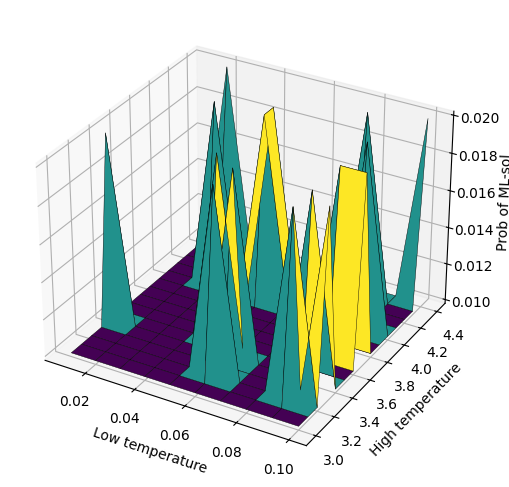

In [85]:
min_vals = np.arange(min_temp1, max_temp1, 0.01)
max_vals = np.arange(min_temp2, max_temp2, 0.1)

results = []

for min_temp in min_vals:
    for max_temp in max_vals:
        # Skip unphysical cases if you want min_temp <= max_temp
        if min_temp > max_temp:
            prob_best = 0
        else:
            res = solver.metropolis_update(
                num_sweeps=n_sweeps,
                num_reads=n_reads,
                num_replicas=n_replicas,
                update_strategy='sequential',
                min_temp=min_temp,
                max_temp=max_temp,
                initialize_strategy='random',
                recompute_energy=False,
                sort_output_temps=True,
                parallel=True,
                verbose=False,
            )

            # Collect the best energies per read from this run
            all_energies = res['best_energy']
            print(all_energies)

            # Find the minimum energy out of all of the reads
            best_energy = all_energies.min()

            # Optionally: empirical probability of best energy within this run
            count_best = np.sum(np.isclose(all_energies, best_energy, atol=1e-6))
            prob_best = count_best / all_energies.size
            print(prob_best)

        results.append(
            dict(
                min_temp=min_temp,
                max_temp=max_temp,
                prob_best=prob_best,
                best_energy=best_energy
            )
        )

sweep_df = pd.DataFrame(results)
display(sweep_df)

# Build a grid of (min_temp, max_temp)
x_vals = np.sort(sweep_df['min_temp'].unique())
y_vals = np.sort(sweep_df['max_temp'].unique())
X, Y = np.meshgrid(x_vals, y_vals)

# Fill Z with prob_best values
Z = np.empty_like(X, dtype=float)
for i, ymin in enumerate(y_vals):
    for j, xmin in enumerate(x_vals):
        mask = (sweep_df['min_temp'] == xmin) & (sweep_df['max_temp'] == ymin)
        Z[i, j] = sweep_df.loc[mask, 'prob_best'].iloc[0] if mask.any() else np.nan

# Plot 3D phase diagram
fig = plt.figure(figsize=(6,7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k', linewidth=0.3)

ax.set_xlabel('Low temperature')
ax.set_ylabel('High temperature')
ax.set_zlabel('Prob of ML-sol')


plt.show()

In [93]:
# Apply Metropolis
res_1 = solver.metropolis_update(
    num_sweeps=n_sweeps,
    num_reads=n_reads,
    num_replicas=n_replicas,
    update_strategy='sequential',
    min_temp=min_temp,
    max_temp=max_temp,
    initialize_strategy='ones',
    recompute_energy=False,
    sort_output_temps=True,
    parallel=True,  # True by default
    verbose=True)

100%|██████████| 100/100 [00:00<00:00, 503.96it/s]


In [94]:
# Check that all the energies match
assert (np.all([
    np.isclose(solver.get_energy(x), e, atol=1e-6)
    for xs, es in tqdm(res_1[['states', 'energies']].values)
    for x, e in zip(xs, es)
]))

100%|██████████| 100/100 [00:00<00:00, 1069.99it/s]


In [6]:
# Temperatures, initial states and initial energies can be provided
res_1b = solver.metropolis_update(num_sweeps=n_sweeps,
                                  num_reads=n_reads,
                                  update_strategy='sequential',
                                  temps=res_1.loc[0].temps,
                                  initialize_strategy=res_1.loc[0].states,
                                  init_energies=res_1.loc[0].energies,
                                  recompute_energy=False,
                                  sort_output_temps=True,
                                  verbose=True)

100%|██████████| 100/100 [00:00<00:00, 516.80it/s]


In [7]:
# Check that all the energies match
assert (np.all([
    np.isclose(solver.get_energy(x), e, atol=1e-6)
    for xs, es in tqdm(res_1b[['states', 'energies']].values)
    for x, e in zip(xs, es)
]))

100%|██████████| 100/100 [00:00<00:00, 1122.31it/s]


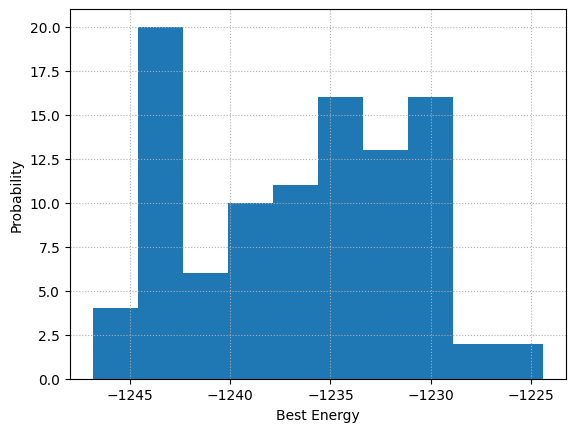

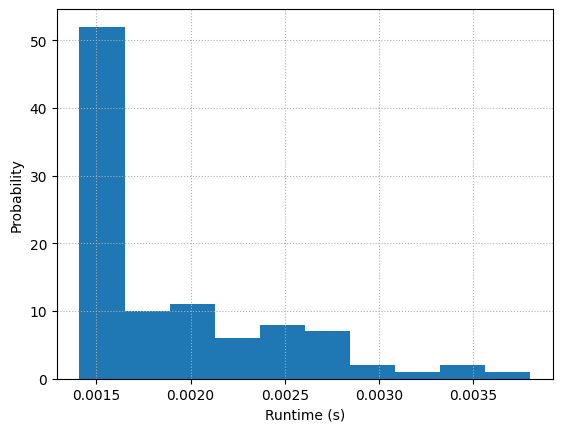

In [95]:
plt.hist(res_1['best_energy'])
plt.grid(ls=':')
plt.xlabel('Best Energy')
plt.ylabel('Probability')
plt.show()

plt.hist(res_1['runtime (us)'] / 1e6)
plt.grid(ls=':')
plt.xlabel('Runtime (s)')
plt.ylabel('Probability')
plt.show()

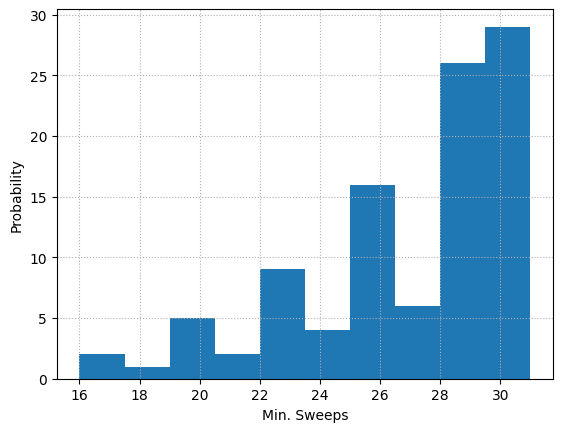

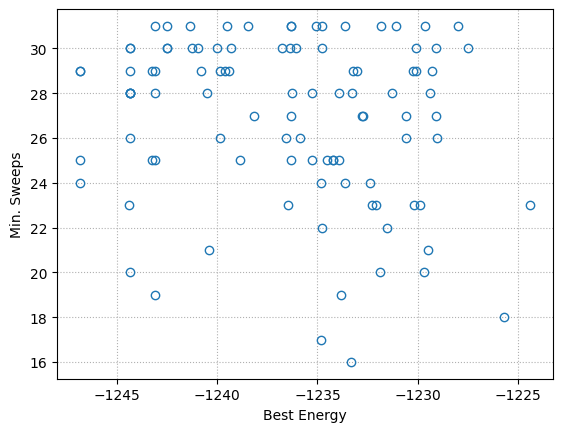

In [96]:
plt.hist(res_1['min_sweeps'])
plt.grid(ls=':')
plt.xlabel('Min. Sweeps')
plt.ylabel('Probability')
plt.show()

plt.plot(*res_1[['best_energy', 'min_sweeps']].values.T, 'o', mfc='none')
plt.xlabel('Best Energy')
plt.ylabel('Min. Sweeps')
plt.grid(ls=':')
plt.show()

In [97]:
# Job can be sent to background 
_handle = solver.metropolis_update(num_sweeps=10 * n_sweeps,
                                   num_reads=n_reads,
                                   num_replicas=n_replicas,
                                   update_strategy='random',
                                   min_temp=min_temp,
                                   max_temp=max_temp,
                                   initialize_strategy='random',
                                   recompute_energy=False,
                                   sort_output_temps=False,
                                   send_background=True,
                                   verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

 44%|████▍     | 44/100 [00:01<00:01, 35.04it/s]

In [98]:
# It should say that the results are not ready
print(f'Results ready? {_handle.done()}')
res_2 = _handle.result() # This call blocks till the results are ready
print(f'Results ready? {_handle.done()}')

 52%|█████▏    | 52/100 [00:01<00:01, 35.26it/s]

Results ready? False


100%|██████████| 100/100 [00:02<00:00, 35.84it/s]

Results ready? True


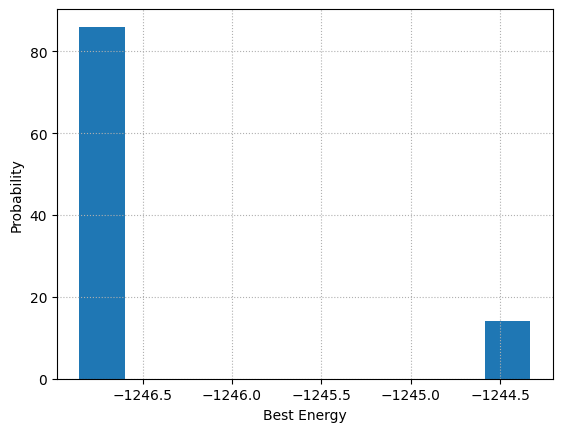

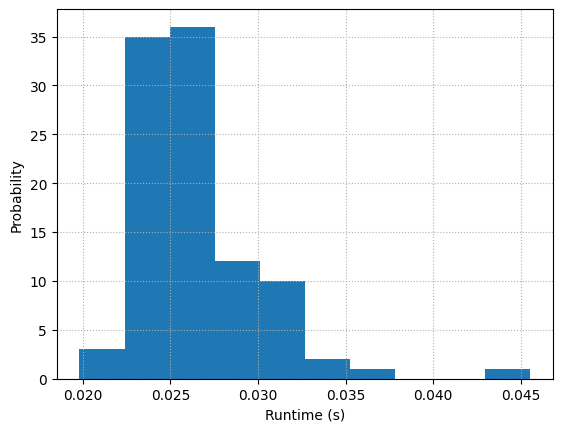

In [99]:
plt.hist(res_2['best_energy'])
plt.grid(ls=':')
plt.xlabel('Best Energy')
plt.ylabel('Probability')
plt.show()

plt.hist(res_2['runtime (us)'] / 1e6)
plt.grid(ls=':')
plt.xlabel('Runtime (s)')
plt.ylabel('Probability')
plt.show()

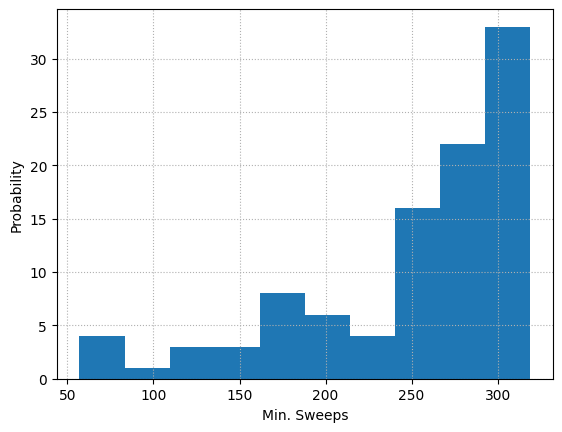

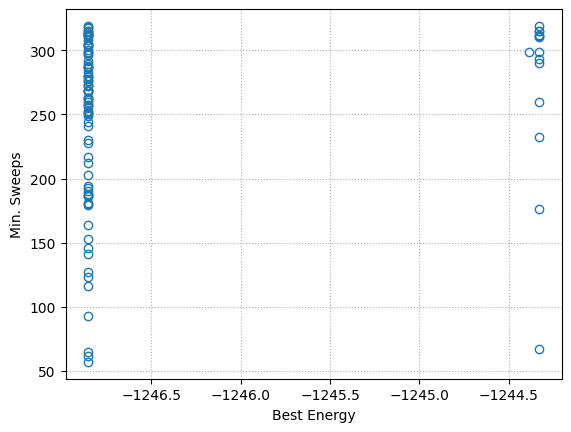

In [100]:
plt.hist(res_2['min_sweeps'])
plt.grid(ls=':')
plt.xlabel('Min. Sweeps')
plt.ylabel('Probability')
plt.show()

plt.plot(*res_2[['best_energy', 'min_sweeps']].values.T, 'o', mfc='none')
plt.xlabel('Best Energy')
plt.ylabel('Min. Sweeps')
plt.grid(ls=':')
plt.show()

In [14]:
# Round-off error can accumulate (if recompute_energy=False)
print(f'Best energy (# sweeps =  {n_sweeps}): {np.min(res_1["best_energy"])}')
print(
    f'Best energy (# sweeps = {10*n_sweeps}): {np.min(res_2["best_energy"])}')

Best energy (# sweeps =  32): -1260.745361328125
Best energy (# sweeps = 320): -1260.7451674118638


In [15]:
# Let's recompute the energy given the best state
print(
    f'Best energy (# sweeps = {n_sweeps}):',
    solver.get_energy(res_1.best_state[np.argmin(res_1.best_energy)])
)
print(
    f'Best energy (# sweeps = {n_sweeps}):',
    solver.get_energy(res_2.best_state[np.argmin(res_2.best_energy)])
)

Best energy (# sweeps = 32): -1260.7451030814445
Best energy (# sweeps = 32): -1260.7451030814445


-----

In [16]:
# Number of variables
n_vars = 32 * 32 * 3
n_replicas = 100

# Generate random problem
problem = 2 * np.random.random((n_vars, n_vars)) - 1
problem = (problem + problem.T) / 2

# Get solver
solver = Solver(problem=problem, problem_type='ising', float_type=float_type)

In [17]:
# Let's define some initial random configurations ...
confs = 2 * np.random.randint(2, size=(n_replicas, n_vars)) - 1

# ... and get the corresponding energies
energies = [solver.get_energy(x) for x in confs]

In [18]:
# Run once to compile
solver.metropolis_update(num_sweeps=1,
                         num_reads=1,
                         update_strategy='sequential',
                         temps=[1] * n_replicas,
                         initialize_strategy=confs,
                         init_energies=energies,
                         recompute_energy=False,
                         sort_output_temps=False,
                         return_dataframe=False,
                         parallel=True,
                         use_pt=False,
                         verbose=False);

In [19]:
%%timeit -n 5 -r 5
_res = solver.metropolis_update(num_sweeps=1,
                                num_reads=1,
                                update_strategy='sequential',
                                temps=[1] * n_replicas,
                                initialize_strategy=confs,
                                init_energies=energies,
                                recompute_energy=False,
                                sort_output_temps=False,
                                return_dataframe=False,
                                parallel=True,
                                use_pt=False,
                                verbose=False)

18.7 ms ± 682 μs per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [20]:
_res = solver.metropolis_update(num_sweeps=1,
                                num_reads=1,
                                update_strategy='sequential',
                                temps=[1] * n_replicas,
                                initialize_strategy=confs,
                                init_energies=energies,
                                recompute_energy=False,
                                sort_output_temps=False,
                                return_dataframe=False,
                                parallel=True,
                                use_pt=False,
                                verbose=False)

# Update configurations and energies
confs = _res[0]['states']
energies = _res[0]['energies']

# Let's check that energies are computed correctly
assert (np.all([
    np.isclose(solver.get_energy(c), e, atol=1e-6)
    for c, e in tqdm(zip(confs, energies), total=len(confs))
]))

100%|██████████| 100/100 [00:01<00:00, 99.65it/s]
